# Keras Notebook

This notebook uses different Convolutional Neural Networks to distinguish between signal and background processes --  ZvvHbb images (signal) and JZ0W images (background). 

In order to do this, we must first convert our data into a convenient format that allows us to load it into a CNN using the Keras API. We also need to make sure that the images are compatible with the DNNDK. The DNNDK requiresthat we have our images saved as JPEG images, so we need to convert our images accordingly from (26,32,1) to (26, 32, 3). 

Then it is a matter of using a convenient CNN model to classify the images. We also look at procedures like normalization to make our training even better as well a s features of the network that are important like Batch Normalization.

In [1]:
import numpy as np
import pandas as pd 
import h5py
import convert_data
import keras

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

from sklearn.utils import shuffle

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

np.random.seed(7)

Using TensorFlow backend.


In [2]:
#This loads all of our data and gives us our images and labels in the format we need

images, labels = convert_data.images_and_labels()
labels = keras.utils.to_categorical(labels, num_classes=2) #changing to one hot encoding

x_tr, x_val, y_tr, y_val = train_test_split(images, labels, test_size=0.5, random_state=42)
x_val, x_te, y_val, y_te = train_test_split(x_val, y_val, test_size=0.1, random_state=42)


#This saves our numpy data into JPEG images

x_tr = x_tr.reshape(-1, 26, 32)
for i, train_image in enumerate(x_tr):
    matplotlib.image.imsave('train_images/' + str(i) + '_train.jpeg',train_image)

x_val = x_val.reshape(-1, 26, 32)
for j, val_image in enumerate(x_val):
    matplotlib.image.imsave('val_images/' + str(j) + '_val.jpeg',val_image)
    
x_te = x_te.reshape(-1, 26, 32)    
for k, test_image in enumerate(x_te):
    matplotlib.image.imsave('test_images/' + str(k) + '_test.jpeg',test_image)



The below code converts our image data into RGB data instead of just single intensity values

In [3]:
from PIL import Image
x_tr = []
for i in range(1000):
    im = Image.open('train_images/'+ str(i) + '_train.jpeg')
    val = list(np.asarray(im))
    x_tr.append(val)

x_tr = np.array(x_tr)
print(x_tr.shape)

x_val = []
for j in range(900):
    im = Image.open('val_images/'+ str(j) + '_val.jpeg')
    val = list(np.asarray(im))
    x_val.append(val)

x_val = np.array(x_val)
print(x_val.shape)

x_te = []
for k in range(100):
    im = Image.open('test_images/'+ str(k) + '_test.jpeg')
    val = list(np.asarray(im))
    x_te.append(val)

x_te = np.array(x_te)
print(x_te.shape)

(1000, 26, 32, 3)
(900, 26, 32, 3)
(100, 26, 32, 3)


# Model Creation

Here we define various different models for training to see what is the most efficient.

We first have a single 2D Convolutional Neural Network (Which includes a Batch Normalization layer, a Flattening layer, and an output layer). Then we have two Conv2D layers, a single Conv2D layer and a MaxPool layer, and finally two Conv2D layers and two MaxPool layers.

The output we use for all of our outputs is softmax -- so a single value of 1 or 0

In [4]:
def model_one_conv_layer():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_1c = model_one_conv_layer()
model_1c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 32, 32)        128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 26624)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 53250     
Total params: 54,274
Trainable params: 54,210
Non-trainable params: 64
_________________________________________________________________


In [5]:
def model_two_conv_layer():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,3)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_2c = model_two_conv_layer()
model_2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 32, 32)        128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 26624)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 53250     
Total params: 63,522
Trainable params: 63,458
Non-trainable params: 64
_________________________________________________________________


In [6]:
def model_one_conv_one_max():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_1c1m = model_one_conv_one_max()
model_1c1m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 16, 32)        128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 6656)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 13314     
Total params: 14,338
Trainable params: 14,274
Non-trainable params: 64
_________________________________________________________________


In [7]:
def model_two_conv_two_max():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_2c2m = model_two_conv_two_max()
model_2c2m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 8, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 8, 32)          128       
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 3074      
Total para

In [8]:
reduce_lr = LearningRateScheduler(lambda x: 1e-2 * 0.7 ** x)
batch_size = 32
epochs = 50

In [9]:
history_1c = model_1c.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=0, callbacks = [reduce_lr], batch_size = batch_size)

In [10]:
history_2c = model_2c.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=0, callbacks = [reduce_lr], batch_size = batch_size)

In [11]:
history_1c1m = model_1c1m.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=0, callbacks = [reduce_lr], batch_size = batch_size)

In [12]:
history_2c2m = model_2c2m.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)

Train on 1000 samples, validate on 900 samples
Epoch 1/50
 - 2s - loss: 1.7646 - acc: 0.7200 - val_loss: 3.4618 - val_acc: 0.7356
Epoch 2/50
 - 1s - loss: 1.0702 - acc: 0.7810 - val_loss: 2.2563 - val_acc: 0.5022
Epoch 3/50
 - 1s - loss: 0.5630 - acc: 0.7980 - val_loss: 0.8861 - val_acc: 0.6700
Epoch 4/50
 - 1s - loss: 0.4886 - acc: 0.7990 - val_loss: 1.3003 - val_acc: 0.5233
Epoch 5/50
 - 1s - loss: 0.4128 - acc: 0.8340 - val_loss: 0.6048 - val_acc: 0.6900
Epoch 6/50
 - 1s - loss: 0.3732 - acc: 0.8410 - val_loss: 2.8722 - val_acc: 0.5022
Epoch 7/50
 - 1s - loss: 0.3473 - acc: 0.8580 - val_loss: 0.4205 - val_acc: 0.7822
Epoch 8/50
 - 1s - loss: 0.3134 - acc: 0.8720 - val_loss: 0.7544 - val_acc: 0.6056
Epoch 9/50
 - 1s - loss: 0.3026 - acc: 0.8710 - val_loss: 1.5959 - val_acc: 0.5022
Epoch 10/50
 - 1s - loss: 0.2990 - acc: 0.8870 - val_loss: 0.6104 - val_acc: 0.6656
Epoch 11/50
 - 1s - loss: 0.2804 - acc: 0.8870 - val_loss: 0.4984 - val_acc: 0.7300
Epoch 12/50
 - 1s - loss: 0.2743 - acc

## Baseline error

This is an indication of how accurate our model is on data it hasn't seen. The best performing was the 2c2m model as can be seen in the bar graph below -- Lower Errors means it identifies a smaller percentage of images incorrectly.

Baseline Error 1C:   12.00%
Baseline Error 2C:   60.00%
Baseline Error 1C1M: 20.00%
Baseline Error 2C2M: 11.00%


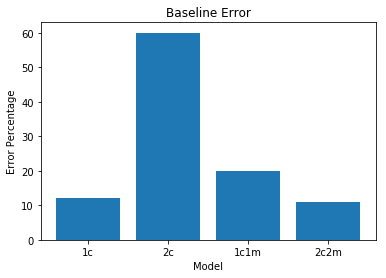

In [13]:
scores_1c   = model_1c.evaluate(x_te, y_te, verbose=0)
scores_2c   = model_2c.evaluate(x_te, y_te, verbose=0)
scores_1c1m = model_1c1m.evaluate(x_te, y_te, verbose=0)
scores_2c2m = model_2c2m.evaluate(x_te, y_te, verbose=0)

print("Baseline Error 1C:   %.2f%%" % (100-scores_1c[1]*100))
print("Baseline Error 2C:   %.2f%%" % (100-scores_2c[1]*100))
print("Baseline Error 1C1M: %.2f%%" % (100-scores_1c1m[1]*100))
print("Baseline Error 2C2M: %.2f%%" % (100-scores_2c2m[1]*100))

x = [0,1,2,3]
plt.bar(x , [100-scores_1c[1]*100, 100-scores_2c[1]*100, 100-scores_1c1m[1]*100, 100-scores_2c2m[1]*100], width=0.8)
plt.xticks(x, ('1c', '2c', '1c1m', '2c2m'))

plt.title('Baseline Error')
plt.ylabel('Error Percentage')
plt.xlabel('Model')

plt.show()

## Model Accuracy

Here we are just looking at the progression of the accuracy of our different models as the epochs progress. 

We can see that the model with 2 convolutional layers and 2 max pooling layers performs the best.

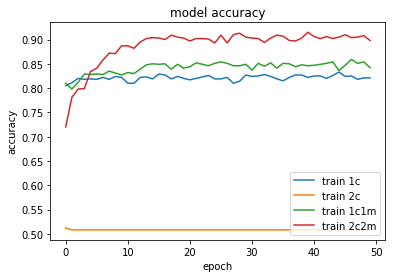

In [14]:
plt.plot(history_1c.history['acc'])
plt.plot(history_2c.history['acc'])
plt.plot(history_1c1m.history['acc'])
plt.plot(history_2c2m.history['acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train 1c', 
            'train 2c', 
            'train 1c1m',
            'train 2c2m',]
           , loc='lower right')
plt.show()

## Model Loss

This is the loss of our models on the training data as the epochs progress 


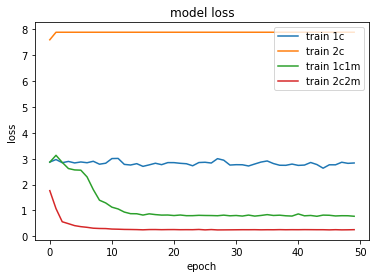

In [15]:
# summarize history for loss

plt.plot(history_1c.history['loss'])
plt.plot(history_2c.history['loss'])
plt.plot(history_1c1m.history['loss'])
plt.plot(history_2c2m.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train 1c',
            'train 2c',
            'train 1c1m',
            'train 2c2m'], loc='upper right')
plt.show()

## Best performing model

In terms of both accuracy and loss, our 2c2m model works the best. Now, we must plot the training and validation values together to see if our model is overfitting.

We can see by the slight disagreement that there is infact overfitting. So we need to modify our dataset such that we can reduce the overfitting of our model.

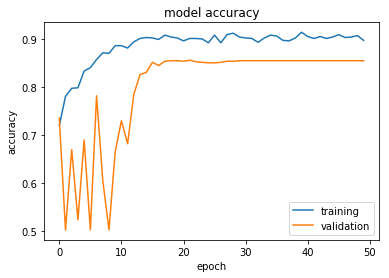

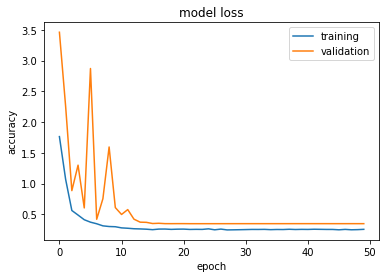

In [16]:
plt.plot(history_2c2m.history['acc'])
plt.plot(history_2c2m.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training',
            'validation'], loc='lower right')

plt.show()

plt.plot(history_2c2m.history['loss'])
plt.plot(history_2c2m.history['val_loss'])

plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training',
            'validation'], loc='upper right')

plt.show()

# Normalization

We try normalizing by the max value of the RGB pixel value but this gives us no change in the valiudation accuracy or loss, so we will have to find another way to address overfitting

In [17]:
x_tr_norm = x_tr/255.
x_val_norm = x_val/255.

In [18]:
model_2c2m_norm = model_two_conv_two_max()
history_2c2m_norm = model_2c2m_norm.fit(x_tr_norm, y_tr, validation_data = (x_val_norm, y_val) ,epochs = epochs, verbose=0, callbacks = [reduce_lr], batch_size = batch_size)

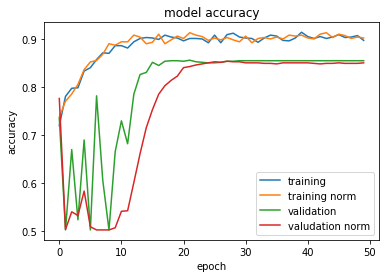

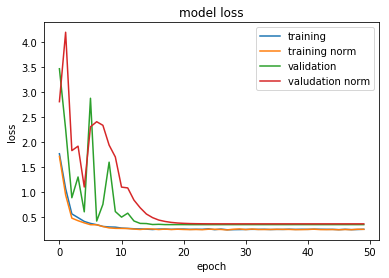

In [19]:
plt.plot(history_2c2m.history['acc'])
plt.plot(history_2c2m_norm.history['acc'])

plt.plot(history_2c2m.history['val_acc'])
plt.plot(history_2c2m_norm.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training',
            'training norm',
            'validation',
            'valudation norm'], loc='lower right')

plt.show()

plt.plot(history_2c2m.history['loss'])
plt.plot(history_2c2m_norm.history['loss'])

plt.plot(history_2c2m.history['val_loss'])
plt.plot(history_2c2m_norm.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training',
            'training norm',
            'validation',
            'valudation norm'], loc='upper right')

plt.show()

# Batch Normalization

Batch Normalization proves to be a very important layer in this model. Without it our model fails horrendously -- it gives us accuracy as good as randomly selecting.

Below we can see how it compares with our regular model.

Batch Normalization works because it reduces the amount by which the hidden unit values shift around and it allows each layer of a network to learn somewhat more independently of other layers

In [20]:
def model_two_conv_two_max_no_batch_norm():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    # model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_2c2m_no_bn = model_two_conv_two_max_no_batch_norm()

history_2c2m_no_bn = model_2c2m_no_bn.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=0, callbacks = [reduce_lr], batch_size = batch_size)


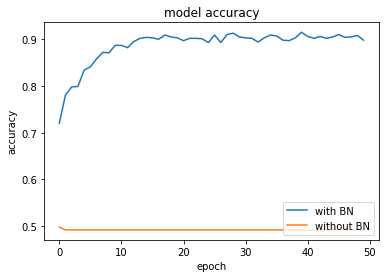

In [21]:
plt.plot(history_2c2m.history['acc'])
plt.plot(history_2c2m_no_bn.history['acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['with BN',
            'without BN'], loc='lower right')

plt.show()

# Improvements to Model

Since we see that Batch Normalization is such an important layer, this begs the question why not add it in at a different point? And since it helps layers learn independently, why not try put it after our first Con2D layer and MaxPool2D layer?

Also, in order to counteract overfitting, we can try adding 2 dropout layers after of the Conv2D and MaxPool2D layers in order to add some noise to our layers when they are learning -- allowing them to pick up on features more accurately


In [22]:
def improved_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

i_model = improved_model()
i_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 8, 32)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 6, 8, 32)          128       
__________

In [23]:
i_history = i_model.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)

Train on 1000 samples, validate on 900 samples
Epoch 1/50
 - 3s - loss: 2.5898 - acc: 0.7490 - val_loss: 1.3388 - val_acc: 0.7756
Epoch 2/50
 - 1s - loss: 1.5067 - acc: 0.7460 - val_loss: 1.8779 - val_acc: 0.5767
Epoch 3/50
 - 1s - loss: 0.8156 - acc: 0.7660 - val_loss: 0.8355 - val_acc: 0.7156
Epoch 4/50
 - 1s - loss: 0.6306 - acc: 0.7720 - val_loss: 0.6624 - val_acc: 0.6689
Epoch 5/50
 - 1s - loss: 0.5496 - acc: 0.7760 - val_loss: 2.1289 - val_acc: 0.5167
Epoch 6/50
 - 1s - loss: 0.5040 - acc: 0.8060 - val_loss: 0.8201 - val_acc: 0.6067
Epoch 7/50
 - 1s - loss: 0.4274 - acc: 0.8160 - val_loss: 0.5420 - val_acc: 0.7744
Epoch 8/50
 - 1s - loss: 0.4014 - acc: 0.8250 - val_loss: 0.6038 - val_acc: 0.7644
Epoch 9/50
 - 1s - loss: 0.4053 - acc: 0.8440 - val_loss: 0.5484 - val_acc: 0.7633
Epoch 10/50
 - 1s - loss: 0.3893 - acc: 0.8390 - val_loss: 0.4160 - val_acc: 0.8156
Epoch 11/50
 - 1s - loss: 0.3892 - acc: 0.8460 - val_loss: 0.4227 - val_acc: 0.8300
Epoch 12/50
 - 1s - loss: 0.3839 - acc

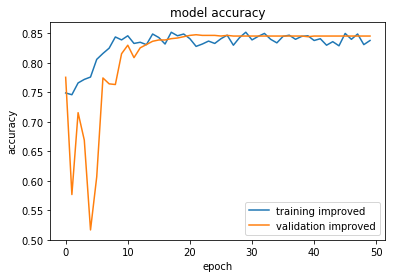

In [24]:
plt.plot(i_history.history['acc'])
plt.plot(i_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training improved',
            'validation improved'], loc='lower right')

plt.show()

# Conclusions from Improved Model

We get an overall lower accuracy, however, we get a much better agreement between our training and validation data which tells us we aredoing a better job of not overfitting.

# Conversion to Tensorflow File

We need a .pb file in order to run convert our models using the DNNDK (Deep Neural Network Development Kit)

We create a frozen graph and use this to get our model.pb file


In [25]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                if node.op == 'RefSwitch':
                    node.op = 'Switch'
                    for index in range(len(node.input)):
                        if 'moving_' in node.input[index] and "Switch" not in node.input[index]:
                            node.input[index] = node.input[index] + '/read'
                elif node.op == 'AssignSub':
                    node.op = 'Sub'
                    if 'use_locking' in node.attr: del node.attr['use_locking']
                elif node.op == 'AssignAdd':
                    node.op = 'Add'
                    if 'use_locking' in node.attr: del node.attr['use_locking']
        node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [26]:
from keras import backend as K
import tensorflow as tf

In [27]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in i_model.outputs])

INFO:tensorflow:Froze 217 variables.
INFO:tensorflow:Converted 217 variables to const ops.


In [28]:
tf.train.write_graph(frozen_graph, "Tensorflow_model", "my_model.pb", as_text=False)

'Tensorflow_model/my_model.pb'